In [1]:
# import the necessary packages
import tensorflow as tf
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import argparse
import locale
import os
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing
import sys

from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
import matplotlib.pyplot as plt
from keras.utils import plot_model
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


In [2]:
print("[INFO] loading house attributes...")
inputPath =  "HousesInfo.txt"
cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
df = pd.read_csv(inputPath, sep=" ", header=None, names=cols)
df.head()


[INFO] loading house attributes...


,bedrooms,bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226


In [3]:
#Pandas Index.value_counts() function returns object containing counts of unique values. The resulting object will be in descending order so that the first element is the most frequently-occurring element. Excludes NA values by default.
zipcodeSeries=df["zipcode"].value_counts()  #<class 'pandas.core.series.Series'>
zipcodes = zipcodeSeries.keys().tolist()   #zipcodes as list
counts = zipcodeSeries.tolist()    #count of zipcodes as list  
for (zipcode, count) in zip(zipcodes, counts):
		# the zip code counts for our housing dataset is *extremely*
		# unbalanced (some only having 1 or 2 houses per zip code)
		# so let's sanitize our data by removing any houses with less
		# than 25 houses per zip code
		if count < 25:
			booleanVal=(df["zipcode"] == zipcode)  # this will be true at all zipcodes that should be deleted
			#print(type(booleanVal))   #<class 'pandas.core.series.Series'>
			idxs = df[booleanVal].index  #this will return indices of these true values
			df.drop(idxs, inplace=True)
print("[INFO]removed zipcodes which less than 25 houses")            

[INFO]removed zipcodes which less than 25 houses


In [4]:
#Normalize  continous values to be between 0 and 1
column_names_to_normalize = ["bedrooms", "bathrooms", "area"]  #continous data
x = df[column_names_to_normalize].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = df.index)
df[column_names_to_normalize] = df_temp
print("[INFO] continous values normalize to be between 0 and 1")

[INFO] continous values normalize to be between 0 and 1


In [5]:
#change categoital data to one hot vector
df['zipcode']=pd.Categorical(df['zipcode'])
dfDummies = pd.get_dummies(df['zipcode'], prefix = 'zipcode')
print(dfDummies.head())
df = pd.concat([df, dfDummies], axis=1)
df.drop(['zipcode'],axis=1,inplace=True)
print("[INFO] Zip code converted to one hot vector")

    zipcode_91901  zipcode_92276  zipcode_92677  zipcode_92880  zipcode_93446  \
30              0              0              0              0              1   
32              0              0              0              0              1   
39              0              0              0              0              1   
80              1              0              0              0              0   
81              1              0              0              0              0   

    zipcode_93510  zipcode_94501  
30              0              0  
32              0              0  
39              0              0  
80              0              0  
81              0              0  
[INFO] Zip code converted to one hot vector


In [6]:
# construct a training and testing split with 75% of the data used
# for training and the remaining 25% for evaluation
print("[INFO] constructing training/testing split...")
(train, test) = train_test_split(df, test_size=0.25, random_state=42)
trainX=(train.drop('price', axis=1)).values
trainY=train["price"].values
testX=(test.drop('price', axis=1)).values
testY=test["price"].values
print("[INFO] train and test data prepared")

[INFO] constructing training/testing split...
[INFO] train and test data prepared


In [7]:
maxPrice = train["price"].max()
trainY=trainY/maxPrice
testY=testY/maxPrice
print("[INFO] Normalized price by printing by max price")

[INFO] Normalized price by printing by max price


In [8]:
print("[INFO] trainX.shape  {}".format(trainX.shape))
print("[INFO]testX.shape {}".format(testX.shape))
print("[INFO] trainY.shape {}".format(trainY.shape))
print("[INFO] testY.shape {}".format(testY.shape))

[INFO] trainX.shape  (271, 10)
[INFO]testX.shape (91, 10)
[INFO] trainY.shape (271,)
[INFO] testY.shape (91,)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


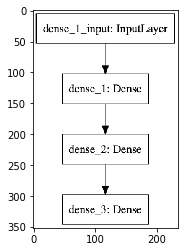

In [10]:
model = Sequential()
model.add(Dense(8, input_dim=trainX.shape[1], activation="relu"))
model.add(Dense(4, activation="relu"))
model.add(Dense(1, activation="linear"))
model.summary()
plot_model(model, to_file='model.png')
import matplotlib.image as mpimg
img=mpimg.imread('model.png')
imgplot = plt.imshow(img)
plt.show()

In [11]:
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)


In [12]:
# train the model
print("[INFO] training model...")
history=model.fit(trainX, trainY, validation_data=(testX, testY),epochs=200, batch_size=8)
model.save("housePrice.keras2")
print("[INFO] model saved to housePrice.keras2")

[INFO] training model...
Instructions for updating:
Use tf.cast instead.
Train on 271 samples, validate on 91 samples
Epoch 1/200
271/271 [==============================] - 1s 4ms/step - loss: 507.3404 - val_loss: 216.8817
Epoch 2/200
271/271 [==============================] - 0s 710us/step - loss: 116.0361 - val_loss: 84.3331
Epoch 3/200
271/271 [==============================] - 0s 627us/step - loss: 65.4680 - val_loss: 70.6753
Epoch 4/200
271/271 [==============================] - 0s 376us/step - loss: 57.5419 - val_loss: 64.7573
Epoch 5/200
271/271 [==============================] - 0s 386us/step - loss: 52.1707 - val_loss: 60.7663
Epoch 6/200
271/271 [==============================] - 0s 384us/step - loss: 48.4241 - val_loss: 55.2817
Epoch 7/200
271/271 [==============================] - 0s 367us/step - loss: 46.2975 - val_loss: 54.9520
Epoch 8/200
271/271 [==============================] - 0s 446us/step - loss: 44.6819 - val_loss: 49.6408
Epoch 9/200
271/271 [====================

271/271 [==============================] - 0s 414us/step - loss: 24.6932 - val_loss: 26.2284
Epoch 76/200
271/271 [==============================] - 0s 385us/step - loss: 23.7702 - val_loss: 25.8843
Epoch 77/200
271/271 [==============================] - 0s 398us/step - loss: 24.0308 - val_loss: 28.0265
Epoch 78/200
271/271 [==============================] - 0s 715us/step - loss: 24.4052 - val_loss: 26.0390
Epoch 79/200
271/271 [==============================] - 0s 341us/step - loss: 23.8590 - val_loss: 28.0165
Epoch 80/200
271/271 [==============================] - 0s 383us/step - loss: 24.5831 - val_loss: 25.7407
Epoch 81/200
271/271 [==============================] - 0s 393us/step - loss: 22.9443 - val_loss: 25.6972
Epoch 82/200
271/271 [==============================] - 0s 392us/step - loss: 23.7548 - val_loss: 26.4922
Epoch 83/200
271/271 [==============================] - 0s 350us/step - loss: 24.1688 - val_loss: 24.9075
Epoch 84/200
271/271 [==============================] - 0s 

Epoch 152/200
271/271 [==============================] - 0s 342us/step - loss: 21.3581 - val_loss: 27.3810
Epoch 153/200
271/271 [==============================] - 0s 360us/step - loss: 19.8310 - val_loss: 23.9935
Epoch 154/200
271/271 [==============================] - 0s 360us/step - loss: 23.0626 - val_loss: 26.5074
Epoch 155/200
271/271 [==============================] - 0s 366us/step - loss: 22.9577 - val_loss: 23.5660
Epoch 156/200
271/271 [==============================] - 0s 374us/step - loss: 20.6142 - val_loss: 24.5825
Epoch 157/200
271/271 [==============================] - 0s 343us/step - loss: 21.2017 - val_loss: 24.7719
Epoch 158/200
271/271 [==============================] - 0s 376us/step - loss: 20.5229 - val_loss: 26.4118
Epoch 159/200
271/271 [==============================] - 0s 360us/step - loss: 21.6247 - val_loss: 26.8296
Epoch 160/200
271/271 [==============================] - 0s 345us/step - loss: 22.6201 - val_loss: 27.7646
Epoch 161/200
271/271 [==============

In [15]:
# make predictions on the testing data
print("[INFO] predicting house prices...")
preds = model.predict(testX)
validationLoss=(history.history['val_loss'])
trainingLoss=history.history['loss']

[INFO] predicting house prices...


[INFO] Loss curve saved to plot_acc.png


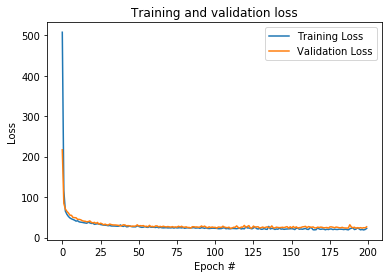

In [17]:
epochs   = range(len(validationLoss)) # Get number of epochs
plt.plot  ( epochs,     trainingLoss ,label="Training Loss")
plt.plot  ( epochs, validationLoss, label="Validation Loss" )
plt.title ('Training and validation loss')
plt.xlabel("Epoch #")
plt.ylabel("Loss")
fileToSaveAccuracyCurve="plot_acc.png"
plt.savefig("plot_acc.png")
print("[INFO] Loss curve saved to {}".format("plot_acc.png"))
plt.legend(loc="upper right")
plt.show()

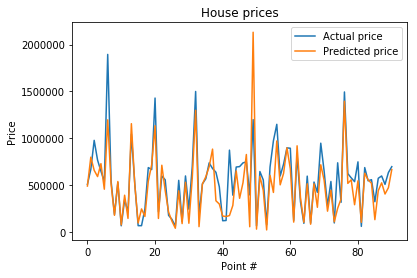

[INFO] predicted vs actual price saved to HousePrices.png


<Figure size 432x288 with 0 Axes>

In [18]:
#readjust house prices
testY=testY*maxPrice
preds=preds*maxPrice
#plot curves (Actual vs Predicted)
plt.plot  ( testY ,label="Actual price")
plt.plot  ( preds, label="Predicted price" )
plt.title ('House prices')
plt.xlabel("Point #")
plt.ylabel("Price")
plt.legend(loc="upper right")
plt.show()
plt.savefig("HousePrices.png")
print("[INFO] predicted vs actual price saved to HousePrices.png")